# 1. 多GPU训练

In [33]:
%matplotlib inline
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

In [34]:
torch.cuda.is_available() # 查看是否有可用GPU

True

In [35]:
torch.cuda.device_count() # 查看GPU数量

4

In [36]:
W = torch.randn(size=(3,4)) # 从标准正态分布（均值为0，方差为1）中抽取的一组随机数。
scale = 0.01
print(W * scale)

tensor([[ 0.0101, -0.0089, -0.0072, -0.0085],
        [ 0.0035, -0.0051,  0.0274,  0.0085],
        [-0.0076,  0.0107,  0.0151, -0.0163]])


In [37]:
# 简单网络 lenet
scale = 0.01
W1 = torch.randn(size=(20,1,3,3)) * scale
b1 = torch.zeros(20)
W2 = torch.randn(size=(50,20,5,5)) * scale
b2 = torch.zeros(50)
W3 = torch.randn(size=(800,128)) * scale
b3 = torch.zeros(128)
W4 = torch.randn(size=(128,10)) * scale
b4 = torch.zeros(10)
params = [W1,b1,W2,b2,W3,b3,W4,b4]

def lenet(X, params):
    h1_conv = F.conv2d(input=X, weight=params[0],bias=params[1])
    h1_activation = F.relu(h1_conv)
    h1 = F.avg_pool2d(input=h1_activation, kernel_size=(2,2), stride=(2,2))
    h2_conv = F.conv2d(input=h1, weight=params[2], bias=params[3])
    h2_activation = F.relu(h2_conv)
    h2 = F.avg_pool2d(input=h2_activation,kernel_size=(2,2),stride=(2,2))
    h2 = h2.reshape(h2.shape[0],-1)
    h3_linear = torch.mm(h2, params[4]) + params[5]
    h3 = F.relu(h3_linear)
    y_hat = torch.mm(h3, params[6]) + params[7]
    return y_hat

loss = nn.CrossEntropyLoss(reduction='none')

In [38]:
# 参数默认在CUP上
# 向多个设备分发参数=把指定参数放在指定GPU上
def get_params(params, device):
    new_params = [p.clone().to(device) for p in params] # 把params中所有参数挪到GPU上    # clone()次数可以省略
    for p in new_params:
        p.requires_grad_() # 每一个参数都要计算梯度
    return new_params

new_params = get_params(params, d2l.try_gpu(0))
print('b1 weight：', new_params[1])
print('b1 grad：', new_params[1].grad)

b1 weight： 

RuntimeError: CUDA error: no kernel image is available for execution on the device
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

In [39]:
# allreduce函数将所有向量相加，并将结果广播给所有GPU
def allreduce(data): # 如果有四个GPU的话，data这个list里面就有四个元素
    for i in range(1, len(data)):
        data[0][:] += data[i].to(data[0].device) # 把其余三个GPU上元素，拷贝到0号GPU上
    for i in range(1, len(data)):
        data[i] = data[0].to(data[i].device) # 把相加后的结果复制回所有GPU上
        
data = [torch.ones((1,2),device=d2l.try_gpu(i)) * (i + 1) for i in range(2)]     
print('before allreduce:\n', data[0], '\n', data[1])
allreduce(data) # allreduce函数可以用于各个GPU的梯度加起来，然后各个GPU拿到合梯度
print('before allreduce:\n', data[0], '\n', data[1])

RuntimeError: CUDA error: no kernel image is available for execution on the device
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

In [ ]:
# 将一个小批量数据均匀地分布在多个GPU上
data = torch.arange(20).reshape(4,5)
devices = [torch.device('cuda:0'),torch.device('cuda:1')]
print('input:',data)
print('load into',devices)
split = nn.parallel.scatter(data,devices) # 将data均匀的切开，放到不同的GPU上   
print('output:',split)

In [ ]:
def split_batch(X, y, devices):
    """将X和y拆分到多个设备上"""
    assert X.shape[0] == y.shape[0] # 确定样本数与标号数是一样的
    return (nn.parallel.scatter(X, devices), nn.parallel.scatter(y, devices)) # 样本与标号都均匀分布到不同GPU上    

In [ ]:
# 在一个小批量上实现多GPU训练
def train_batch(X, y, device_params, devices, lr):
    X_shards, y_shards = split_batch(X, y, devices) # 把X，y分到不同GPU上
    # 拿到每一个GPU上的X_shard、y_shard以及对应的device_W
    # sum是对每一个GPU上所有样本的损失求和
    # ls返回的是每一个GPU上对应的损失
    ls = [loss(lenet(X_shard, device_W),y_shard).sum() 
          for X_shard, y_shard, device_W in zip(X_shards, y_shards, device_params)]                         
    for l in ls:
        l.backward() # 对每一个GPU的loss做负反馈，算梯度
    with torch.no_grad():
        for i in range(len(device_params[0])):
            # i是层，c是GPU
            allreduce([device_params[c][i].grad for c in range(len(devices))])
        for param in device_params: # 拿到所有梯度后，对每一个GPU做SGD
            d2l.sgd(param, lr, X.shape[0])

In [ ]:
# 训练
def train(num_gpus, batch_size, lr):
    train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
    devices = [d2l.try_gpu(i) for i in range(num_gpus)] # 创建多少个GPU
    device_params = [get_params(params, d) for d in devices] # 初始化的params复制到每个GPU上
    num_epochs = 10
    animator = d2l.Animator('epoch','test acc',xlim=[1,num_epochs])
    timer = d2l.Timer()
    for epoch in range(num_epochs):
        timer.start()
        for X, y in train_iter:
            train_batch(X, y, device_params, devices, lr)
            torch.cuda.synchronize() # 等待所有的GPU算完
        timer.stop()
        animator.add(epoch+1,(d2l.evaluate_accuracy_gpu(
            lambda x: lenet(x,device_params[0]),test_iter,devices[0]),))  
    print(f'test acc: {animator.Y[0][-1]:.2f}, {timer.avg():.1f} sec/epoch'
         f'on {str(devices)}')   

In [40]:
help(torch.cuda.synchronize)

Help on function synchronize in module torch.cuda:

synchronize(device: Union[torch.device, str, int, NoneType] = None) -> None
    Waits for all kernels in all streams on a CUDA device to complete.
    
    Args:
        device (torch.device or int, optional): device for which to synchronize.
            It uses the current device, given by :func:`~torch.cuda.current_device`,
            if :attr:`device` is ``None`` (default).



RuntimeError: CUDA error: no kernel image is available for execution on the device
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

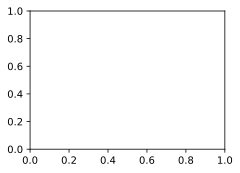

In [41]:
# 在单个GPU上运行
train(num_gpus=1, batch_size=256, lr=0.2)

RuntimeError: CUDA error: no kernel image is available for execution on the device
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

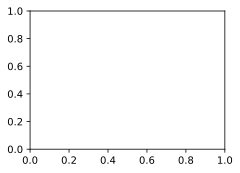

In [42]:
# 增加为2个GPU
train(num_gpus=2, batch_size=256, lr=0.2) # 本电脑只有一个GPU，呜呜呜呜

# 2. 多GPU的简洁实现

In [ ]:
import torch
from torch import nn
from d2l import torch as d2l

In [ ]:
def resnet18(num_classes, in_channels=1):
    """稍加修改的ResNet-18模型"""
    def resnet_block(in_channels, out_channels, num_residuals, first_block=False):   
        blk = []
        for i in range(num_residuals):
            if i == 0 and not first_block:
                blk.append(d2l.Residual(in_channels, out_channels, use_1x1conv=True,strides=2))    
            else:
                blk.append(d2l.Residual(out_channels,out_channels))
        return nn.Sequential(*blk)
        
    net = nn.Sequential(
        nn.Conv2d(in_channels,64,kernel_size=3,stride=1,padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU())  
        
    net.add_module("resnet_block1", resnet_block(64,64,2,first_block=True))
    net.add_module("resnet_block2", resnet_block(64,128,2))
    net.add_module("resnet_block3", resnet_block(128,256,2))
    net.add_module("resnet_block4", resnet_block(256,512,2))
    net.add_module("resnet_avg_pool", nn.AdaptiveAvgPool2d((1,1)))
    net.add_module("fc", nn.Sequential(nn.Flatten(), nn.Linear(512, num_classes)))  

    return net
    
net = resnet18(10)
devices = d2l.try_all_gpus()

In [ ]:
# 训练
def train(net, num_gpus, batch_size, lr):
    train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
    devices = [d2l.try_gpu(i) for i in range(num_gpus)]
    
    def init_weights(m):
        if type(m) in [nn.Linear, nn.Conv2d]:
            nn.init.normal_(m.weight, std=0.01)
            
    net.apply(init_weights)
    # nn.DataParallel会的是X切开并行到各个GPU上，并行算梯度，然后loss加起来，它重新定义了net的forward函数
    net = nn.DataParallel(net, device_ids=devices) # net会复制到每一个GPU上
    trainer = torch.optim.SGD(net.parameters(),lr)
    loss = nn.CrossEntropyLoss()
    timer, num_epochs = d2l.Timer(), 10
    animator = d2l.Animator('epoch','test acc', xlim=[1, num_epochs])  
    for epoch in range(num_epochs):
        net.train()
        timer.start()
        for X, y in train_iter:
            trainer.zero_grad()
            X, y = X.to(devices[0]), y.to(devices[0])
            l = loss(net(X), y)
            l.backward()
            trainer.step()
        timer.stop()
        animator.add(epoch+1, (d2l.evaluate_accuracy_gpu(net, test_iter),))    
    print(f'test acc: {animator.Y[0][-1]:.2f}, {timer.avg():.1f} sec/epoch'
         f'on {str(devices)}')

In [ ]:
help(nn.DataParallel)

In [ ]:
# 在单个GPU上训练网络
train(net, num_gpus=1, batch_size=256, lr=0.1)

In [ ]:
# 使用2个GPU进行训练
train(net, num_gpus=2, batch_size=512, lr=0.2)